In [71]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
from typing import List, Tuple, Dict, Optional

from collections import defaultdict
from typing import List                                                                                                         
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
# 30 sec

In [72]:
from Enum.EnergyRange import EnergyRange
from Enum.Flavour import Flavour

In [73]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

## they all have $W^O$ in the attention layer

In [74]:
csvs = {
    # "ROPE(epoch=13)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_13.csv",
    # "ROPE(epoch=17)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_17.csv",
    # "ROPE(epoch=20)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_20.csv",
    "ROPE(epoch=23)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_23.csv",
    # "ROPE(epoch=26)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_26.csv",
    # "ROPE(epoch=29)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_29.csv",
    # "ROPE(epoch=32)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250513/model_20250511_140515/143709/predictions_epoch_32.csv",
    }

In [75]:
def dup_check(csvs:dict):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        dupe_counts = df['event_no'].value_counts()
        dupes = dupe_counts[dupe_counts > 1]
        pd.options.display.float_format = '{:.0f}'.format
        print(dupes)
dup_check(csvs)

Series([], Name: count, dtype: int64)


In [76]:
# df = pd.read_csv(csvs["8SiLU,T5,256,T5,(029)"])

In [77]:
# df["event_no"].astype(str).str[:3].value_counts()

In [78]:
def get_nu_logits(df: pd.DataFrame, flavour: Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["logit_softmax"] = df["logit_softmax"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")

    nu_e_logit = nu_e["logit_softmax"].apply(lambda x: x[index]).to_numpy()
    nu_mu_logit = nu_mu["logit_softmax"].apply(lambda x: x[index]).to_numpy()
    nu_tau_logit = nu_tau["logit_softmax"].apply(lambda x: x[index]).to_numpy()
    
    return nu_e_logit, nu_mu_logit, nu_tau_logit


In [79]:
def get_nu_output(df: pd.DataFrame, flavour: Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["model_outputs"] = df["model_outputs"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")

    nu_e_output = nu_e["model_outputs"].apply(lambda x: x[index]).to_numpy()
    nu_mu_output = nu_mu["model_outputs"].apply(lambda x: x[index]).to_numpy()
    nu_tau_output = nu_tau["model_outputs"].apply(lambda x: x[index]).to_numpy()
    
    return nu_e_output, nu_mu_output, nu_tau_output


In [80]:
def fraction_above_threshold(arr: np.ndarray, threshold: float = 0.9) -> float:
    return np.mean(arr > threshold)

In [81]:
def plot_multi_flavour_ROC(df: pd.DataFrame, id: str) -> None:
    fig, ax = plt.subplots(figsize=(17, 11))

    ref_fpr = None
    ref_thresholds = None

    for colour_i, flavour in [(2, Flavour.E), (0, Flavour.MU), (1, Flavour.TAU)]:
        nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)

        y_true = np.concatenate([
            np.ones_like(nu_e_logit) if flavour == Flavour.E else np.zeros_like(nu_e_logit),
            np.ones_like(nu_mu_logit) if flavour == Flavour.MU else np.zeros_like(nu_mu_logit),
            np.ones_like(nu_tau_logit) if flavour == Flavour.TAU else np.zeros_like(nu_tau_logit),
        ])
        y_score = np.concatenate([nu_e_logit, nu_mu_logit, nu_tau_logit])

        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=fr"${flavour.latex}$ (AUC = {roc_auc:.3f})",
                linewidth=2, color=getColour(colour_i), markersize=1)

        if ref_fpr is None and ref_thresholds is None:
            ref_fpr = fpr
            ref_thresholds = thresholds

    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(fr"ROC Curves by Flavour, {id}")
    ax.legend(loc="lower right", fontsize=16)

    # Custom top axis for selected logit values
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # Manually chosen logit values
    manual_thresholds = [0.9, 0.75, 0.5, 0.25, 0.1, 0.0]

    # Match each logit threshold to closest FPR index
    ref_thresholds = np.array(ref_thresholds)
    ref_fpr = np.array(ref_fpr)
    tick_indices = [np.argmin(np.abs(ref_thresholds - t)) for t in manual_thresholds]

    ax2.set_xticks(ref_fpr[tick_indices])
    ax2.set_xticklabels([f"{t:.2f}" for t in manual_thresholds])
    ax2.set_xlabel("Logit Thresholds")


In [82]:
def plot_binary_flavour_ROC(df: pd.DataFrame, signal_flavour: Flavour, id: str) -> None:
    fig, ax = plt.subplots(figsize=(17, 11))

    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, signal_flavour)

    all_logits = {
        Flavour.E: nu_e_logit,
        Flavour.MU: nu_mu_logit,
        Flavour.TAU: nu_tau_logit
    }

    y_true = []
    y_score = []

    for flavour, logits in all_logits.items():
        y_true.append(np.ones_like(logits) if flavour == signal_flavour else np.zeros_like(logits))
        y_score.append(logits)

    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # make a residual flavour name list, by excluding the signal flavour from all_logits.keys()
    residual_flavours = [flavour for flavour in all_logits.keys() if flavour != signal_flavour]
    label_roc = (
        fr"$\bf{signal_flavour.latex}$ vs "
        fr"(${residual_flavours[0].latex}$+${residual_flavours[1].latex}$)"
        + "\n" + f"AUC = {roc_auc:.3f}"
    )
        
    ax.plot(fpr, tpr, linewidth=2, color=getColour(0), markersize=1, label=label_roc)

    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(fr"Binary ROC Curve (${signal_flavour.latex}$ as Signal), {id}")
    ax.legend(loc="lower right", fontsize=22)

    # Top axis: logit thresholds
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # manual_thresholds = [0.9, 0.75, 0.5, 0.25, 0.1, 0.0]
    # thresholds = np.array(thresholds)
    # tick_indices = [np.argmin(np.abs(thresholds - t)) for t in manual_thresholds]

    # ax2.set_xticks(fpr[tick_indices])
    # ax2.set_xticklabels([f"{t:.2f}" for t in manual_thresholds])
    # ax2.set_xlabel("Logit Thresholds")


In [83]:
def plot_logit_distribution(df: pd.DataFrame, 
                            flavour: Flavour,
                            id: str,
                            manifier: Tuple[float, float] = None) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_tau_logit, binwidth=0.005)
    
    max_logit = np.max([np.max(nu_e_logit), np.max(nu_mu_logit), np.max(nu_tau_logit)])
    threshold = 0.9 * max_logit
    abs_threshold = 0.0
    label_e = (
        fr"$\bf{Flavour.E.latex}$ (N={len(nu_e_logit)})" + "\n"
        + fr"frac>{threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_e_logit, threshold):.3f}}}$" + "\n"
        + fr"frac>{abs_threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_e_logit, abs_threshold):.3f}}}$"
    )

    label_mu = (
        fr"$\bf{Flavour.MU.latex}$ (N={len(nu_mu_logit)})" + "\n"
        + fr"frac>{threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_mu_logit, threshold):.3f}}}$" + "\n"
        + fr"frac>{abs_threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_mu_logit, abs_threshold):.3f}}}$"
    )

    label_tau = (
        fr"$\bf{Flavour.TAU.latex}$ (N={len(nu_tau_logit)})" + "\n"
        + fr"frac>{threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_tau_logit, threshold):.3f}}}$" + "\n"
        + fr"frac>{abs_threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_tau_logit, abs_threshold):.3f}}}$"
    )

    fig, ax = plt.subplots(figsize=(17, 11))
    # ax.hist(nu_e_logit, bins=bins, label=fr"${Flavour.E.latex}$", color=getColour(2), histtype='step', linewidth=1)
    # ax.hist(nu_mu_logit, bins=bins, label=fr"${Flavour.MU.latex}$", color=getColour(0), histtype='step', hatch='\\', linewidth=1)
    # ax.hist(nu_tau_logit, bins=bins, label=fr"${Flavour.TAU.latex}$", color=getColour(1), histtype='step', hatch ='//', linewidth=1)
    ax.hist(nu_e_logit, bins=bins, color=getColour(2), histtype='step', linewidth=1, label=label_e)
    ax.hist(nu_mu_logit, bins=bins, color=getColour(0), histtype='step', hatch='\\', linewidth=1, label=label_mu)
    ax.hist(nu_tau_logit, bins=bins, color=getColour(1), histtype='step', hatch ='//', linewidth=1, label=label_tau)
    
    ax.set_title(fr"${flavour.latex}$ logit Distribution, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('Frequency')
    

    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-1.5, 0.5)
    ax.legend(fontsize=20)

In [84]:
def plot_output_distribution(df: pd.DataFrame, 
                            flavour: Flavour,
                            id: str,
                            manifier: Tuple[float, float] = None) -> None:
    # nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    
    nu_e_output, nu_mu_output, nu_tau_output = get_nu_output(df, flavour)
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_tau_output, binwidth=0.005)
    
    max_logit = np.max([np.max(nu_e_output), np.max(nu_mu_output), np.max(nu_tau_output)])
    threshold = 0.9 * max_logit
    abs_threshold = 0.80
    label_e = (
        fr"$\bf{Flavour.E.latex}$ (N={len(nu_e_output)})" + "\n"
        + fr"frac>{threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_e_output, threshold):.3f}}}$" + "\n"
        + fr"frac>{abs_threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_e_output, abs_threshold):.3f}}}$"
    )

    label_mu = (
        fr"$\bf{Flavour.MU.latex}$ (N={len(nu_mu_output)})" + "\n"
        + fr"frac>{threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_mu_output, threshold):.3f}}}$" + "\n"
        + fr"frac>{abs_threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_mu_output, abs_threshold):.3f}}}$"
    )

    label_tau = (
        fr"$\bf{Flavour.TAU.latex}$ (N={len(nu_tau_output)})" + "\n"
        + fr"frac>{threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_tau_output, threshold):.3f}}}$" + "\n"
        + fr"frac>{abs_threshold:.2f} = " + fr"$\mathbf{{{fraction_above_threshold(nu_tau_output, abs_threshold):.3f}}}$"
    )

    fig, ax = plt.subplots(figsize=(17, 11))
    # ax.hist(nu_e_logit, bins=bins, label=fr"${Flavour.E.latex}$", color=getColour(2), histtype='step', linewidth=1)
    # ax.hist(nu_mu_logit, bins=bins, label=fr"${Flavour.MU.latex}$", color=getColour(0), histtype='step', hatch='\\', linewidth=1)
    # ax.hist(nu_tau_logit, bins=bins, label=fr"${Flavour.TAU.latex}$", color=getColour(1), histtype='step', hatch ='//', linewidth=1)
    ax.hist(nu_e_output, bins=bins, color=getColour(2), histtype='step', linewidth=1, label=label_e)
    ax.hist(nu_mu_output, bins=bins, color=getColour(0), histtype='step', hatch='\\', linewidth=1, label=label_mu)
    ax.hist(nu_tau_output, bins=bins, color=getColour(1), histtype='step', hatch ='//', linewidth=1, label=label_tau)
    
    ax.set_title(fr"${flavour.latex}$ Output Distribution, {id}")
    ax.set_xlabel('Output')
    ax.set_ylabel('Frequency')
    

    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-0.1, 1.1)
    ax.legend(fontsize=20)

In [85]:
def plot_csvs(csvs:dict, is_magnifier_on:bool):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        
        # plot_logit_distribution(df, Flavour.E, id)
        # if is_magnifier_on:
        #     plot_logit_distribution(df, Flavour.E, id, manifier=(0.8, 1.0))
        # plot_logit_distribution(df, Flavour.MU, id)
        # if is_magnifier_on:
            # plot_logit_distribution(df, Flavour.MU, id, manifier=(0.8, 1.0))
        # plot_logit_distribution(df, Flavour.TAU, id)
        plot_output_distribution(df, Flavour.TAU, id)
        # if is_magnifier_on:
        #     plot_logit_distribution(df, Flavour.TAU, id, manifier=(0.8, 1.1))
        # plot_multi_flavour_ROC(df, id)
        plot_binary_flavour_ROC(df, Flavour.TAU, id)

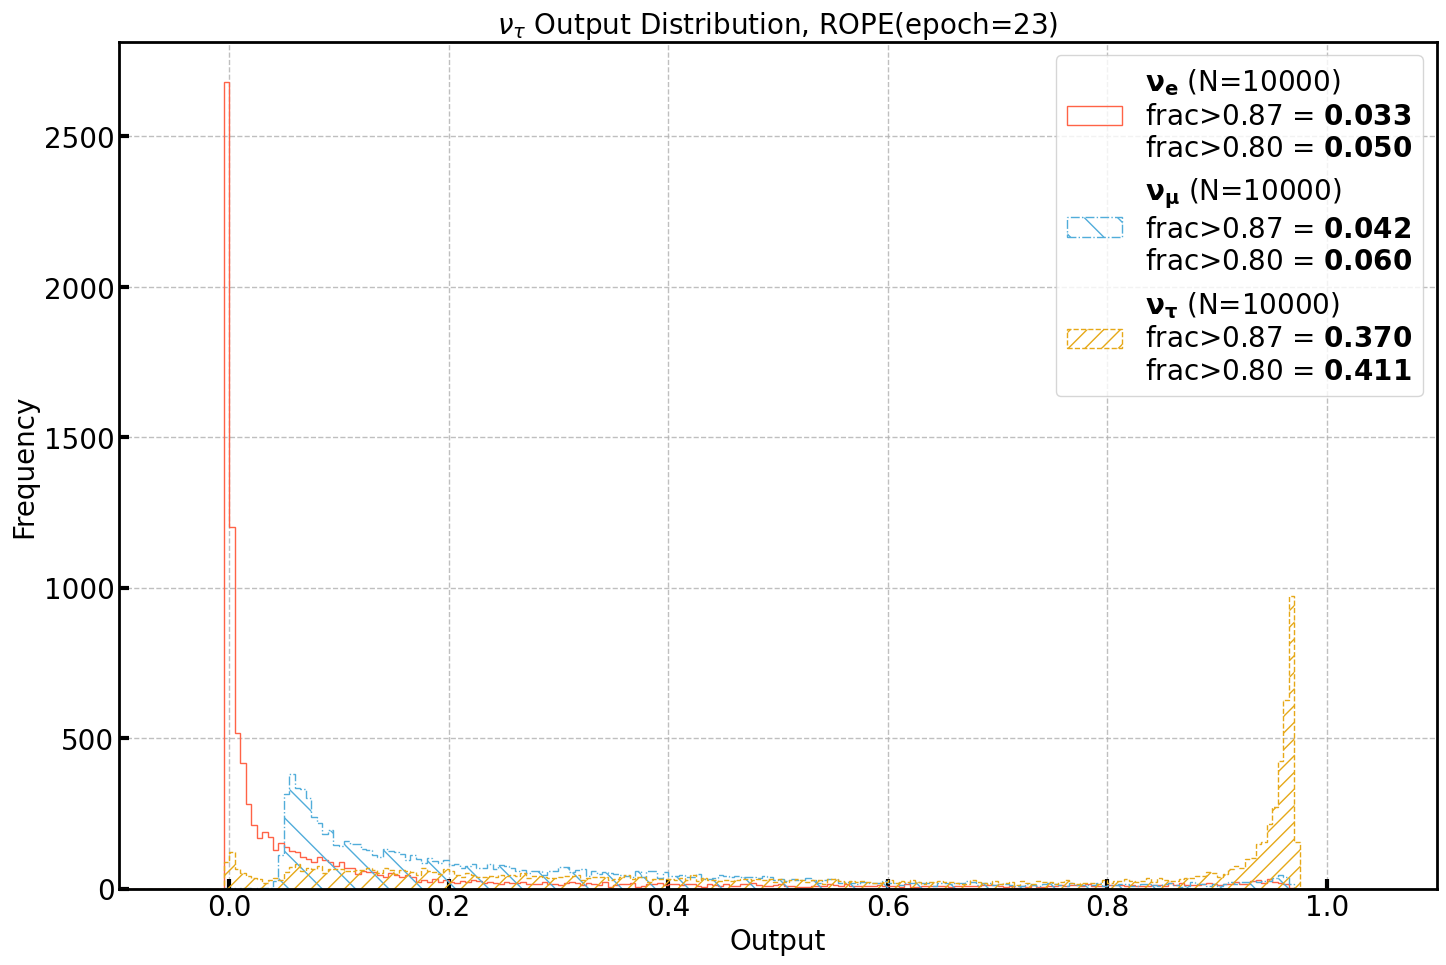

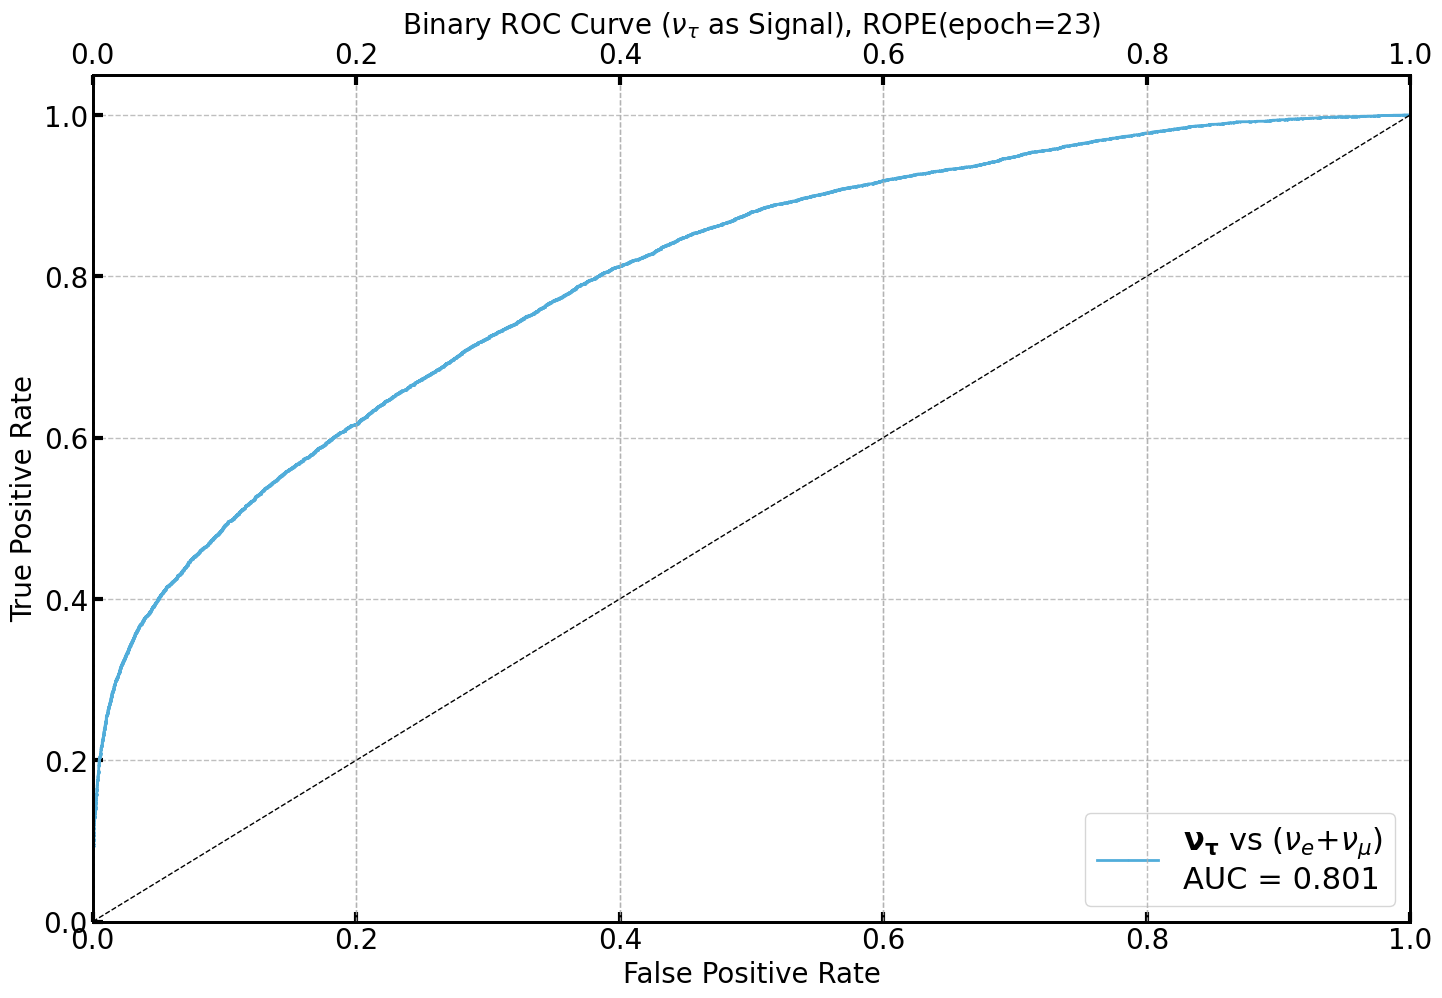

In [86]:
plot_csvs(csvs, is_magnifier_on=False)

In [87]:
def collect_run_metrics(df: pd.DataFrame, id: str) -> Tuple[Dict[Flavour, Dict[str, float]], float, float]:
    """Collect all metrics for a single run, always using ντ-logits for all stats."""
    metrics: Dict[Flavour, Dict[str, float]] = {}

    df["logits"] = df["logits"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    nu_e_tau = df[df["target_class"] == 0]["logits"].apply(lambda x: x[2]).to_numpy()
    nu_mu_tau = df[df["target_class"] == 1]["logits"].apply(lambda x: x[2]).to_numpy()
    nu_tau_tau = df[df["target_class"] == 2]["logits"].apply(lambda x: x[2]).to_numpy()

    all_tau_logits = np.concatenate([nu_e_tau, nu_mu_tau, nu_tau_tau])
    max_tau_logit = np.max(all_tau_logits)
    threshold = 0.9 * max_tau_logit
    abs_threshold = 0.85

    for flavour, logits in zip(
        [Flavour.E, Flavour.MU, Flavour.TAU],
        [nu_e_tau, nu_mu_tau, nu_tau_tau]
    ):
        metrics[flavour] = {
            "median": float(np.median(logits)),
            "frac_thresh": float(fraction_above_threshold(logits, threshold)),
            "frac_abs": float(fraction_above_threshold(logits, abs_threshold)),
        }

    for flavour in [Flavour.E, Flavour.MU, Flavour.TAU]:
        nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
        y_true = np.concatenate([
            np.ones_like(nu_e_logit) if flavour == Flavour.E else np.zeros_like(nu_e_logit),
            np.ones_like(nu_mu_logit) if flavour == Flavour.MU else np.zeros_like(nu_mu_logit),
            np.ones_like(nu_tau_logit) if flavour == Flavour.TAU else np.zeros_like(nu_tau_logit),
        ])
        y_score = np.concatenate([nu_e_logit, nu_mu_logit, nu_tau_logit])
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        metrics[flavour]["auc"] = float(roc_auc)

    return metrics, threshold, abs_threshold


In [88]:
def markdown_table_from_metrics(metrics: Dict[Flavour, Dict[str, float]],
                                threshold: float,
                                abs_threshold: float) -> str:
    headers = [
        "Flavour", "AUC", "(τ) Median",
        f"(τ) Frac > {threshold:.3f}", f"(τ) Frac > {abs_threshold:.3f}"
    ]
    lines = ["| " + " | ".join(headers) + " |",
             "| " + " | ".join(["---"] * len(headers)) + " |"]

    for flavour in [Flavour.E, Flavour.MU, Flavour.TAU]:
        m = metrics.get(flavour, {})
        row = [
            f"${flavour.latex}$",
            f"{m.get('auc', float('nan')):.3f}",
            f"{m.get('median', float('nan')):.3f}",
            f"{m.get('frac_thresh', float('nan')):.3f}",
            f"{m.get('frac_abs', float('nan')):.3f}",
        ]
        lines.append("| " + " | ".join(row) + " |")
    return "\n".join(lines)

In [89]:
def report_csvs(csvs: dict):
    for id, path in csvs.items():
        df = pd.read_csv(path)
        metrics, t, at = collect_run_metrics(df, id)
        print(f"\n### Metrics for `{id}`\n")
        print(markdown_table_from_metrics(metrics, t, at))



In [90]:
# report_csvs(csvs)
# 20sec

In [91]:
def get_energy(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["energy"] = df["energy"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    nu_e_energy = nu_e["energy"].to_numpy()
    nu_mu_energy = nu_mu["energy"].to_numpy()
    nu_tau_energy = nu_tau["energy"].to_numpy()

    return nu_e_energy, nu_mu_energy, nu_tau_energy

In [92]:
def get_zenith(df:pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["zenith"] = df["zenith"].apply(safe_parse) # in radian

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    nu_e_zenith = nu_e["zenith"].to_numpy()
    nu_mu_zenith = nu_mu["zenith"].to_numpy()
    nu_tau_zenith = nu_tau["zenith"].to_numpy()
    nu_e_zenith = np.rad2deg(nu_e_zenith)
    nu_mu_zenith = np.rad2deg(nu_mu_zenith)
    nu_tau_zenith = np.rad2deg(nu_tau_zenith)
    return nu_e_zenith, nu_mu_zenith, nu_tau_zenith

In [93]:
def plot_true_energy(energy: np.ndarray,
                             flavour: Flavour,
                             energy_range: EnergyRange,
                             id: str = None,
                             binwidth: float = 0.25,) -> None:
    log_energy = np.log10(energy)
    bins = np.arange(np.min(log_energy), np.max(log_energy) + binwidth, binwidth)
    counts, edges = np.histogram(log_energy, bins=bins)
    centres = 0.5 * (edges[:-1] + edges[1:])
    bar_width = binwidth * 0.55

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.bar(centres, counts, width=bar_width, edgecolor='black', align='center')
    ax.set_xlabel('log₁₀(Energy [GeV])')
    ax.set_ylabel('Events')
    title = f"Total event count per energy bin"
    if flavour:
        title += f" for true ${flavour.latex}$"
    if id:
        title += f" – {id}"
    ax.set_title(title)
    
    if energy_range:
        if energy_range == EnergyRange.ER_1_PEV_100_PEV:
            ax.set_xlim(6, 8)
        elif energy_range == EnergyRange.ER_10_TEV_1_PEV:
            ax.set_xlim(4, 6)
        elif energy_range == EnergyRange.ER_100_GEV_10_TEV:
            ax.set_xlim(2, 4)
        elif energy_range == EnergyRange.ER_100_TEV_100_PEV:
            ax.set_xlim(5, 8)


In [94]:
def plot_true_zenith(zenith: np.ndarray,
                              flavour: Flavour,
                              energy_range: EnergyRange,
                              id: str = None,
                              binwidth: float = 22.5) -> None:
    bins = np.arange(0, 180 + binwidth, binwidth)
    counts, edges = np.histogram(zenith, bins=bins)
    centres = 0.5 * (edges[:-1] + edges[1:])
    
    fig, ax = plt.subplots(figsize=(18, 6))
    bar_width = binwidth * 0.55
    ax.bar(centres, counts, width=bar_width, edgecolor='black', align='center', color='peru')
    
    ax.set_xlabel('Zenith [degrees]')
    ax.set_ylabel('Events')
    
    title = f"Total event count per zenith bin"
    if flavour:
        title += f" for true ${flavour.latex}$"
    if energy_range:
        title += f" in {energy_range.latex}"
    if id:
        title += f" – {id}"
    ax.set_title(title)
    
    ax.set_xlim(0, 180)


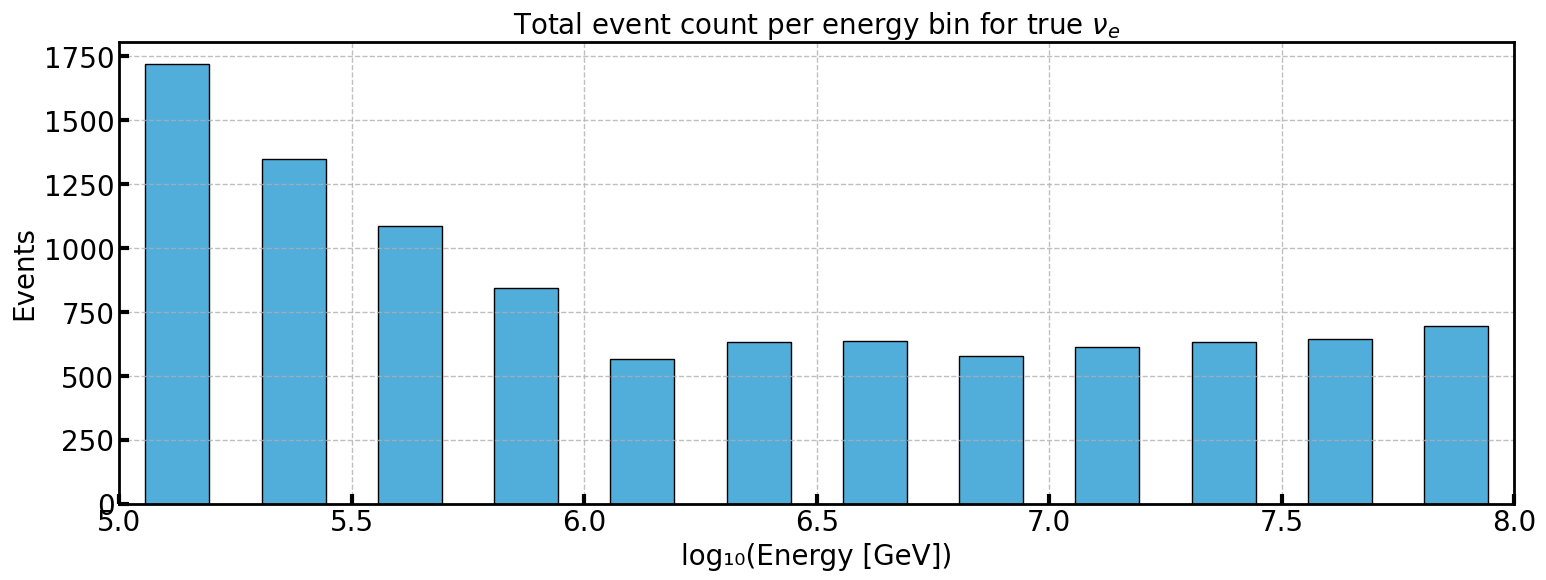

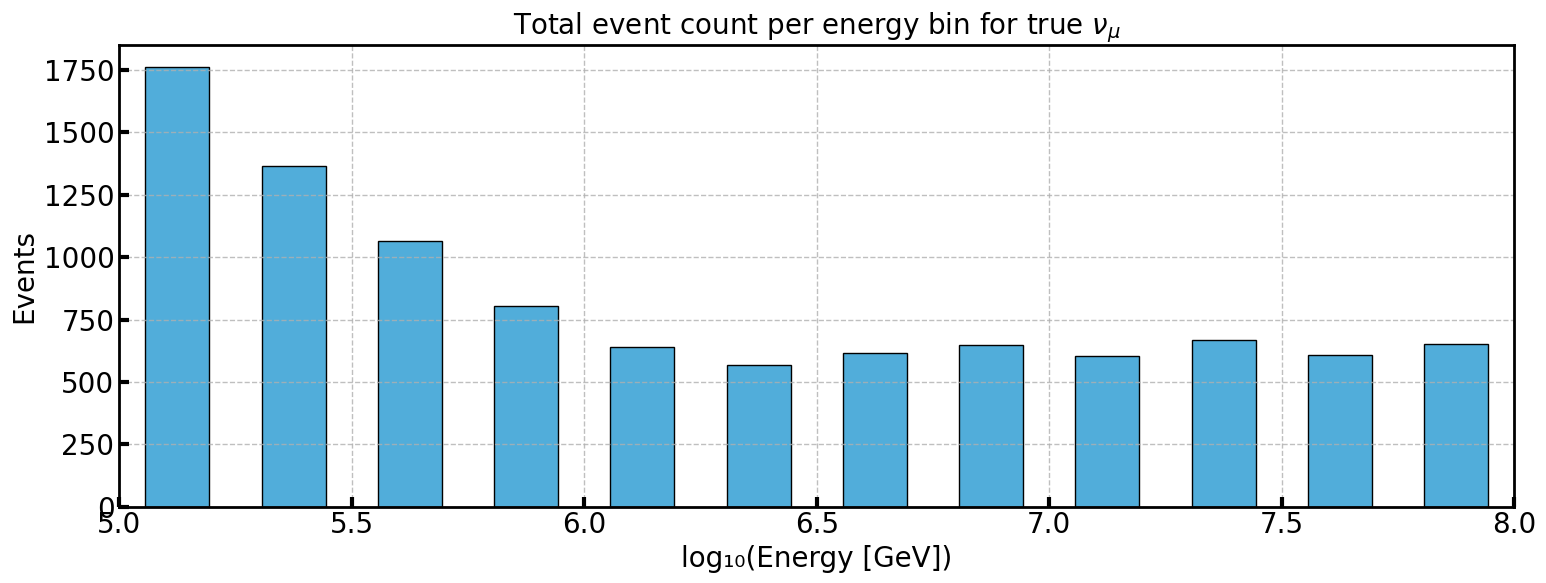

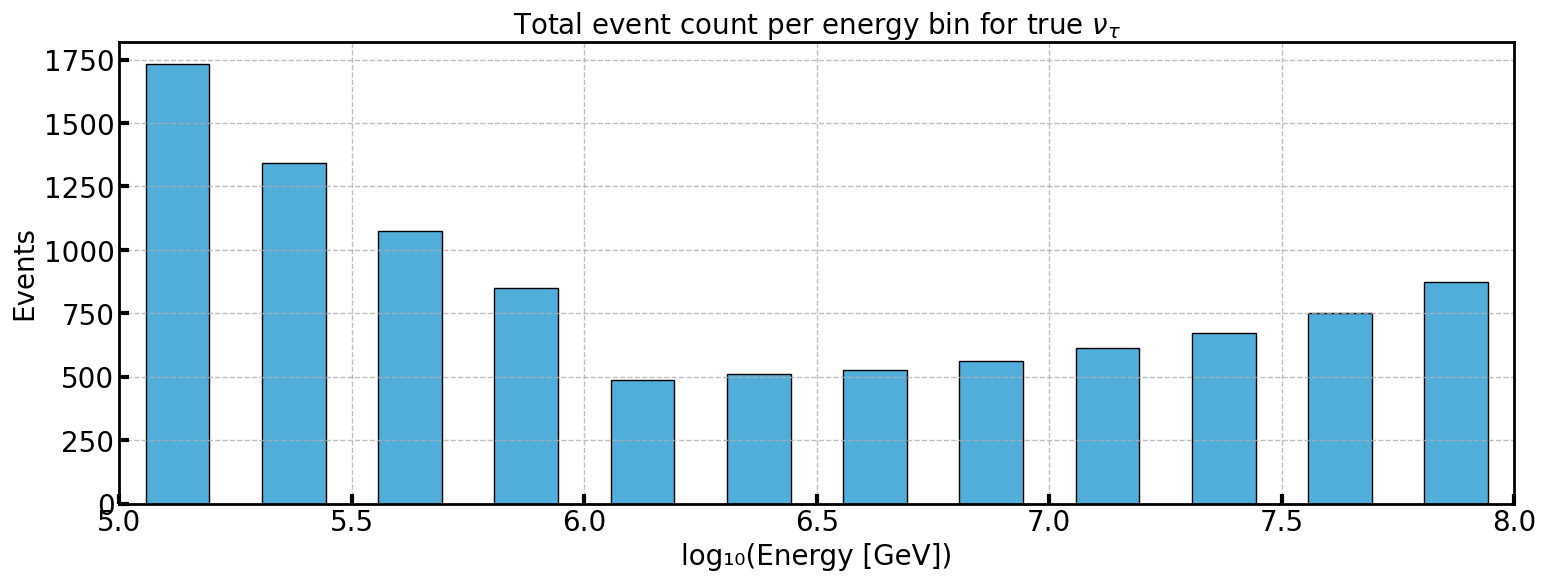

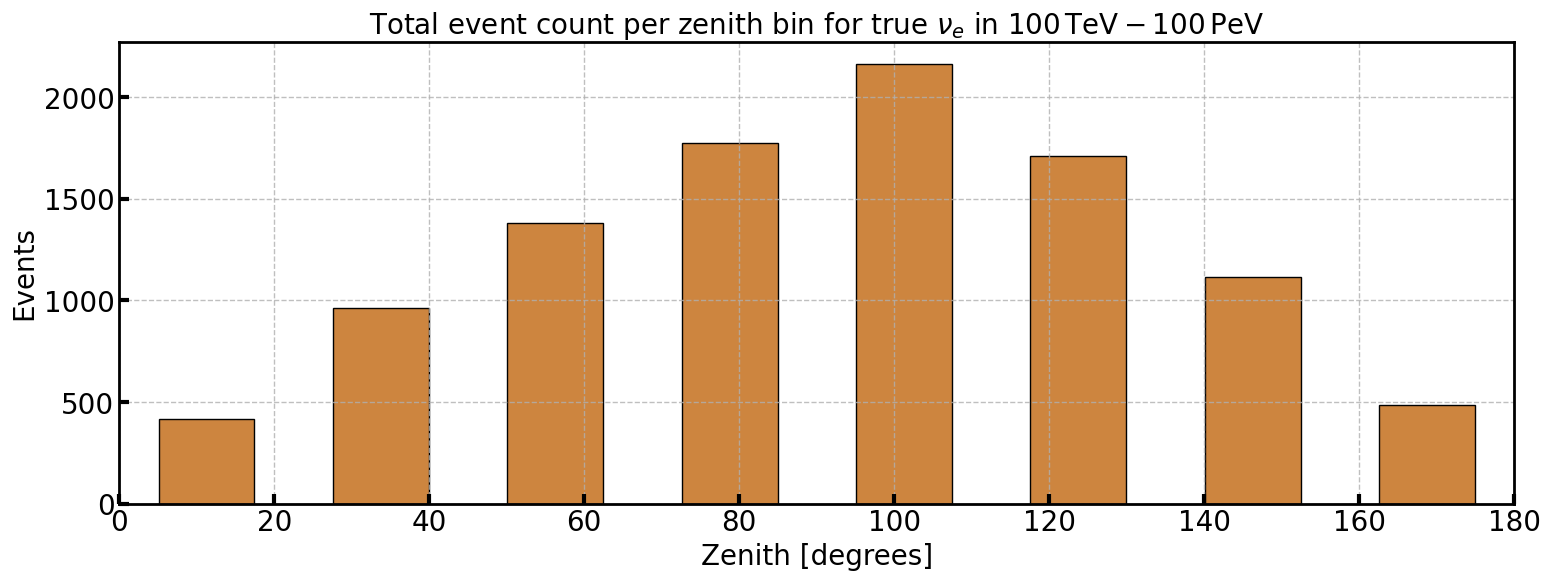

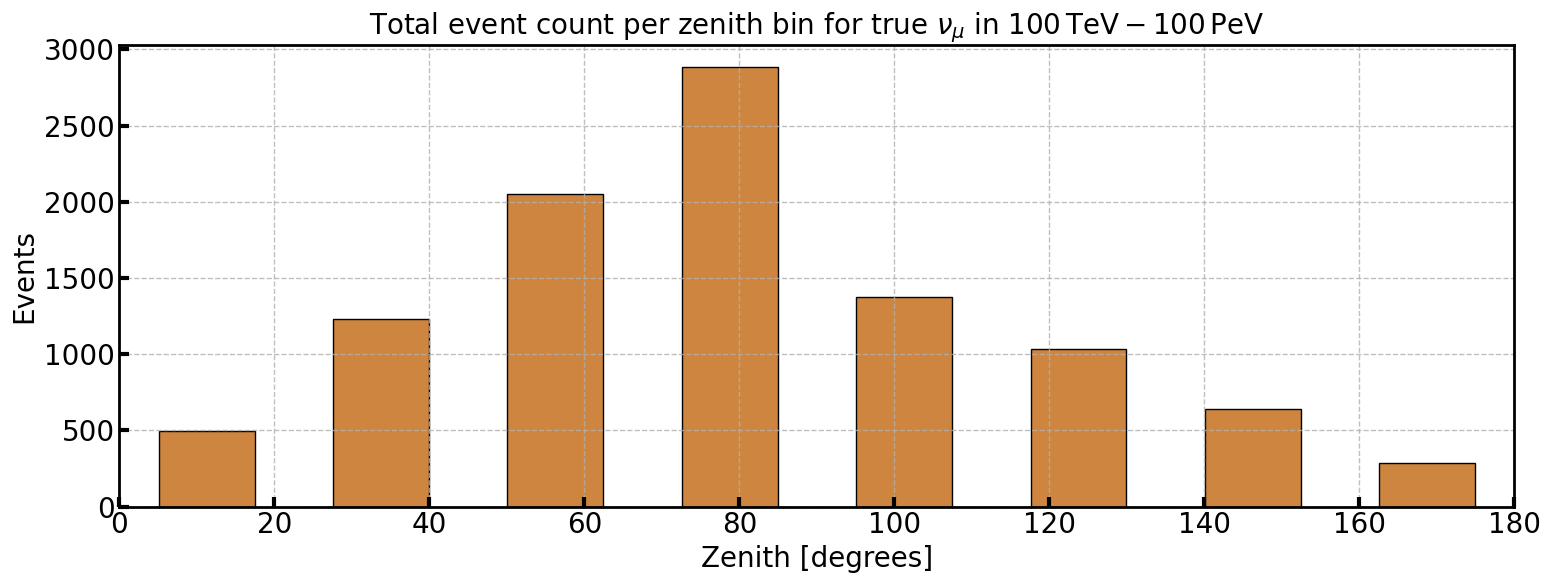

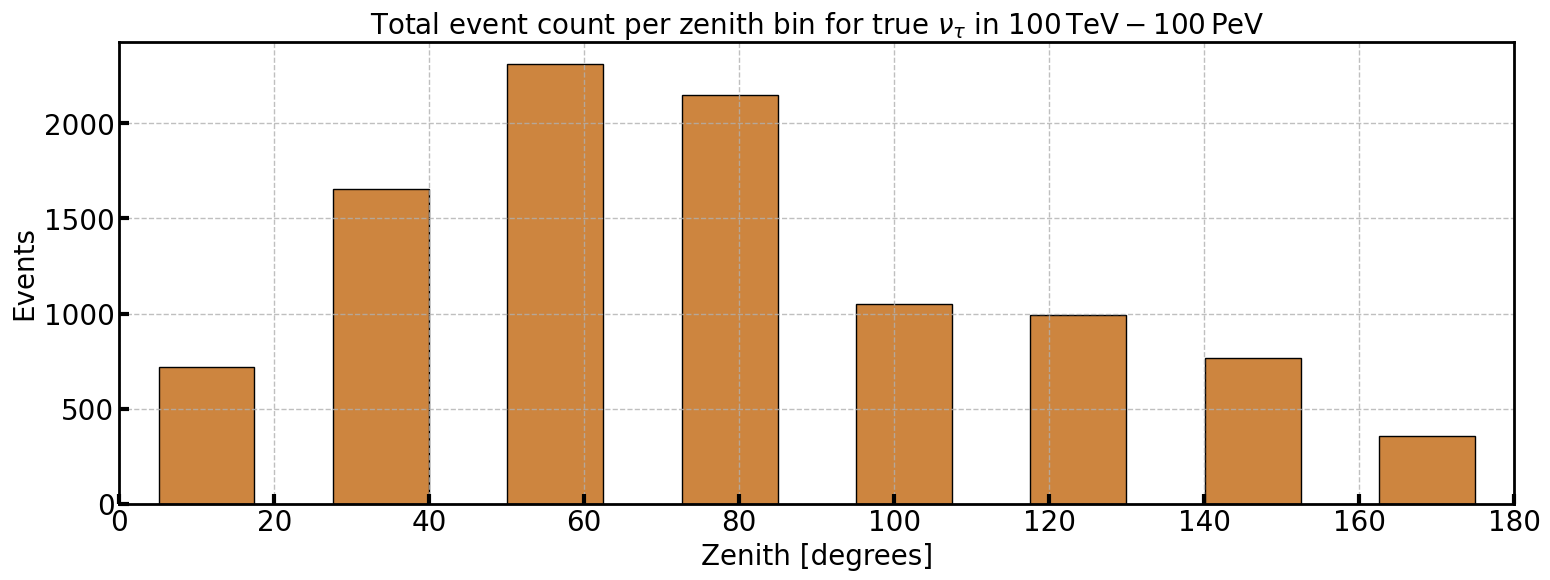

In [95]:
def plot_energy_zenith(csvs: dict):
    id, path=next(iter(csvs.items()))
    df = pd.read_csv(path)
    er = EnergyRange.ER_100_TEV_100_PEV
    e_energy, mu_energy, tau_energy = get_energy(df)
    e_zenith, mu_zenith, tau_zenith = get_zenith(df)
    plot_true_energy(e_energy, Flavour.E, er)
    plot_true_energy(mu_energy, Flavour.MU, er)
    plot_true_energy(tau_energy, Flavour.TAU, er)
    plot_true_zenith(e_zenith, Flavour.E, er)
    plot_true_zenith(mu_zenith, Flavour.MU, er)
    plot_true_zenith(tau_zenith, Flavour.TAU, er)
    
plot_energy_zenith(csvs)

In [96]:

def plot_log_energy_logit_distribution_mono_flavour(nu_logit : np.ndarray,
                                                    energy: np.ndarray,
                                                    logit_flavour: Flavour,
                                                    flavour: Flavour, 
                                                    energy_range: EnergyRange,
                                                    id: str,
                                                    normalise_by_energy: bool = True) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_logit, binwidth=0.3)
    log_energy_binwidth = 0.25
    log_energy = np.log10(energy)
    log_energy_bin = np.arange(np.min(log_energy), np.max(log_energy), log_energy_binwidth)

    # Swapped axes: Energy (x), Logit (y)
    raw_counts, xedges, yedges = np.histogram2d(log_energy, nu_logit, bins=[log_energy_bin, bins])
    H = raw_counts.copy()
    
    if normalise_by_energy:
        # Now energy is along x-axis, so normalise column-wise → axis=1
        H = H / (H.sum(axis=1, keepdims=True) + 1e-8)


    fig, ax = plt.subplots(figsize=(18, 12))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlGnBu', shading='auto')
    fig.colorbar(mesh, ax=ax, label="Frequency" if not normalise_by_energy else "Frequency normalised within energy bin")

    ax.set_title(fr"log₁₀(Energy [GeV])–logit ${logit_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('log₁₀(Energy [GeV])')
    ax.set_ylabel('Logit')
    ax.set_ylim(-1.5, 0.5)

    # Energy range limits (on x-axis now)
    if energy_range == EnergyRange.ER_1_PEV_100_PEV:
        ax.set_xlim(6, 8)
    elif energy_range == EnergyRange.ER_10_TEV_1_PEV:
        ax.set_xlim(4, 6)
    elif energy_range == EnergyRange.ER_100_GEV_10_TEV:
        ax.set_xlim(2, 4)
    elif energy_range == EnergyRange.ER_100_TEV_100_PEV:
        ax.set_xlim(5, 8)

    # Annotate
    max_norm = np.max(H)
    xcentres = 0.5 * (xedges[:-1] + xedges[1:])
    ycentres = 0.5 * (yedges[:-1] + yedges[1:])
    for i in range(len(xcentres)):
        for j in range(len(ycentres)):
            count = raw_counts[i, j]
            norm = H[i, j]
            if count > 0:
                relative_intensity = norm / max_norm
                text_colour = 'white' if relative_intensity > 0.5 else 'black'
                ax.text(xcentres[i], ycentres[j], f"{int(count)}\n({norm:.2f})",
                        ha='center', va='center', fontsize=12, color=text_colour)

    # Energy bin totals → now on x-axis
    # energy_bin_totals = raw_counts.sum(axis=1)  # Sum over y-axis bins
    # # Plot total counts beneath the logit=0 line
    # for i, x in enumerate(xcentres):
    #     ax.text(x, -0.02, f"{int(energy_bin_totals[i])}",
    #             ha='center', va='top', fontsize=12, weight='bold')

    # # Label "Total" aligned with total row, outside the left of the plot
    # ax.text(xcentres[-1] + 0.20, -0.02, "Total", ha='left', va='top', fontsize=12, weight='bold')



In [97]:

def plot_log_energy_output_distribution_mono_flavour(nu_output : np.ndarray,
                                                    energy: np.ndarray,
                                                    output_flavour: Flavour,
                                                    flavour: Flavour, 
                                                    energy_range: EnergyRange,
                                                    id: str,
                                                    normalise_by_energy: bool = True) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_output, binwidth=0.1)
    log_energy_binwidth = 0.25
    log_energy = np.log10(energy)
    log_energy_bin = np.arange(np.min(log_energy), np.max(log_energy), log_energy_binwidth)

    # Swapped axes: Energy (x), Logit (y)
    raw_counts, xedges, yedges = np.histogram2d(log_energy, nu_output, bins=[log_energy_bin, bins])
    H = raw_counts.copy()
    
    if normalise_by_energy:
        # Now energy is along x-axis, so normalise column-wise → axis=1
        H = H / (H.sum(axis=1, keepdims=True) + 1e-8)


    fig, ax = plt.subplots(figsize=(18, 12))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlGnBu', shading='auto')
    fig.colorbar(mesh, ax=ax, label="Frequency" if not normalise_by_energy else "Frequency normalised within energy bin")

    ax.set_title(fr"log₁₀(Energy [GeV])–Output ${output_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('log₁₀(Energy [GeV])')
    ax.set_ylabel('Output')
    ax.set_ylim(-0.1, 1.1)

    # Energy range limits (on x-axis now)
    if energy_range == EnergyRange.ER_1_PEV_100_PEV:
        ax.set_xlim(6, 8)
    elif energy_range == EnergyRange.ER_10_TEV_1_PEV:
        ax.set_xlim(4, 6)
    elif energy_range == EnergyRange.ER_100_GEV_10_TEV:
        ax.set_xlim(2, 4)
    elif energy_range == EnergyRange.ER_100_TEV_100_PEV:
        ax.set_xlim(5, 8)

    # Annotate
    max_norm = np.max(H)
    xcentres = 0.5 * (xedges[:-1] + xedges[1:])
    ycentres = 0.5 * (yedges[:-1] + yedges[1:])
    for i in range(len(xcentres)):
        for j in range(len(ycentres)):
            count = raw_counts[i, j]
            norm = H[i, j]
            if count > 0:
                relative_intensity = norm / max_norm
                text_colour = 'white' if relative_intensity > 0.5 else 'black'
                ax.text(xcentres[i], ycentres[j], f"{int(count)}\n({norm:.2f})",
                        ha='center', va='center', fontsize=12, color=text_colour)



In [98]:
def plot_energy_distribution(df: pd.DataFrame, 
                                   flavour: Flavour,
                                   energy_range: EnergyRange,
                                   id: str) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    nu_e_output, nu_mu_output, nu_tau_output = get_nu_output(df, flavour)
    e_energy, mu_energy, tau_energy = get_energy(df)
    
    plot_log_energy_logit_distribution_mono_flavour(nu_tau_logit, tau_energy, flavour, Flavour.TAU, energy_range, id, normalise_by_energy=True)
    plot_log_energy_output_distribution_mono_flavour(nu_tau_output, tau_energy, flavour, Flavour.TAU, energy_range, id, normalise_by_energy=True)

In [99]:
def plot_csvs_energy(csvs:dict, energy_range: EnergyRange):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        plot_energy_distribution(df, Flavour.TAU, energy_range, id)

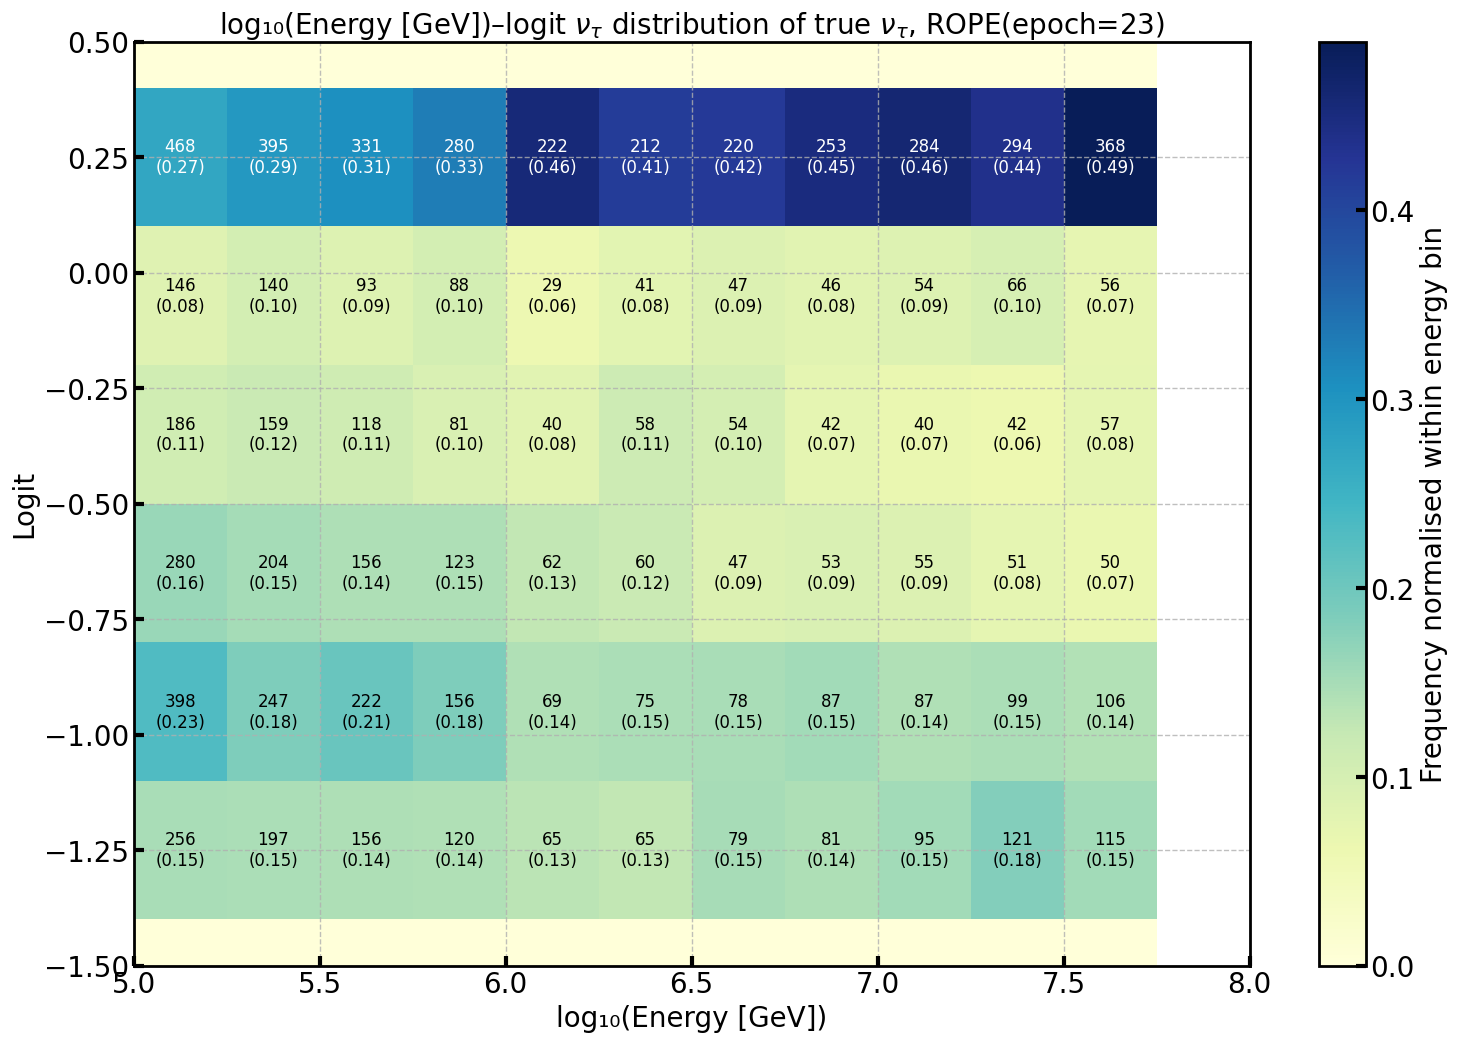

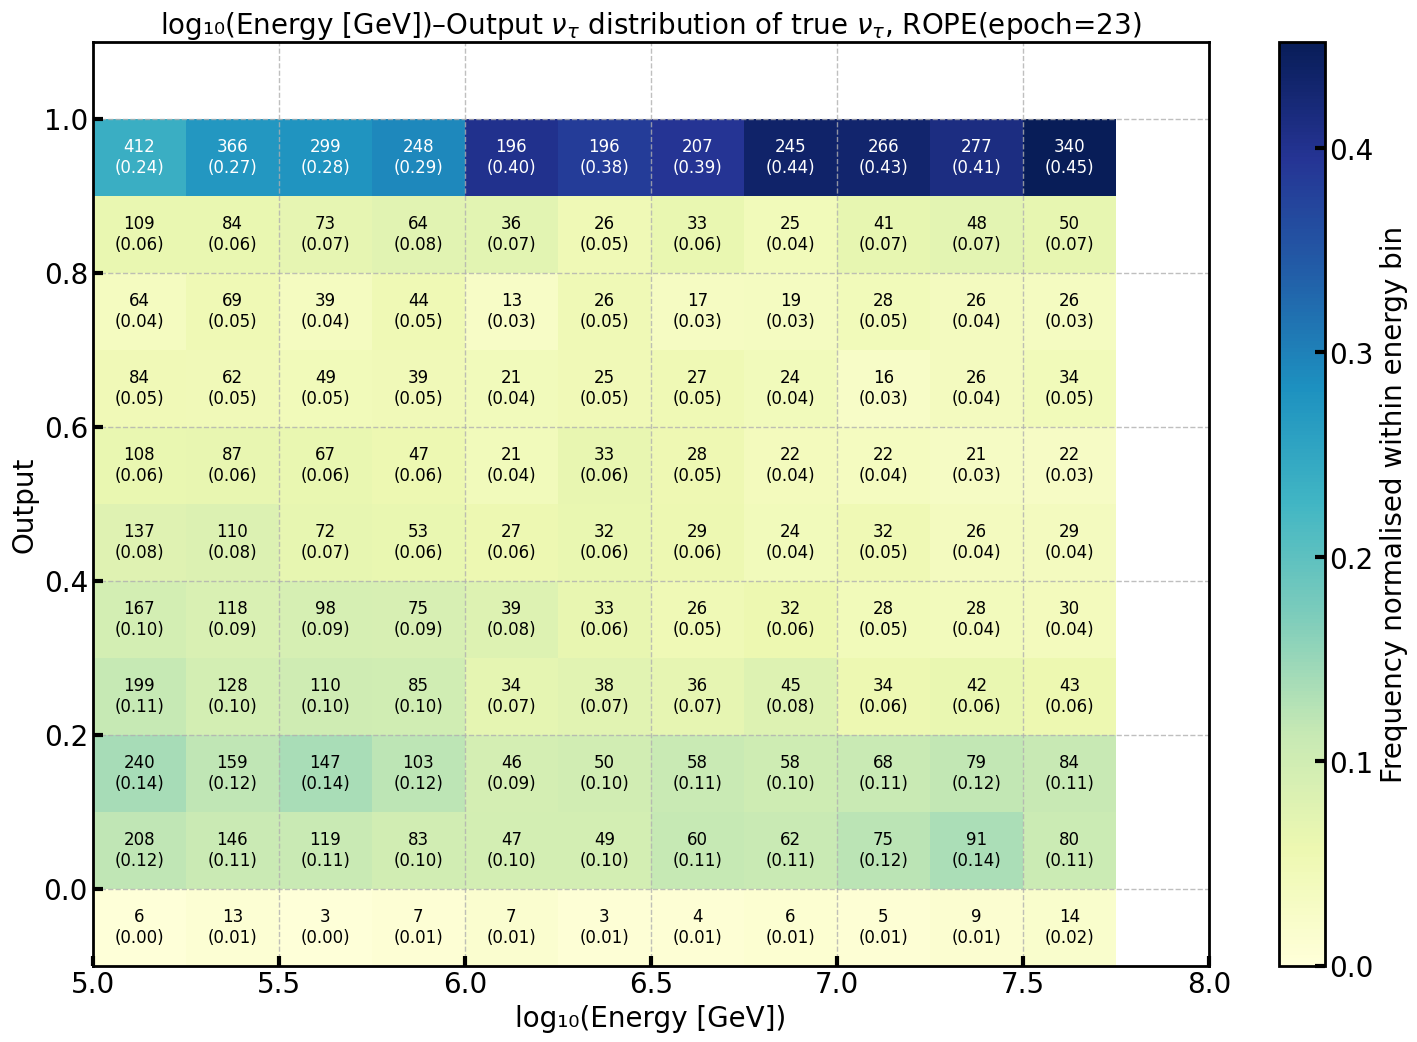

In [100]:
plot_csvs_energy(csvs, EnergyRange.ER_100_TEV_100_PEV)
# 

In [101]:
def plot_zenith_logit_distribution_mono_flavour(nu_logit : np.ndarray,
                                                nu_zenith: np.ndarray,
                                                logit_flavour: Flavour,
                                                flavour: Flavour, 
                                                id: str) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_logit, binwidth=0.3)
    zenith_binwidth = 22.5
    zenith_bin = np.arange(0, 180 + zenith_binwidth, zenith_binwidth)

    # Swap to zenith (x), logit (y)
    raw_counts, xedges, yedges = np.histogram2d(nu_zenith, nu_logit, bins=[zenith_bin, bins])
    H = raw_counts / (raw_counts.sum(axis=1, keepdims=True) + 1e-8)  # normalise by zenith bin (now rows)

    fig, ax = plt.subplots(figsize=(18, 13.5))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlOrBr', shading='auto')
    fig.colorbar(mesh, ax=ax, label="Counts normalised within zenith bin")

    ax.set_title(fr"Zenith–logit ${logit_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('Zenith [degree]')
    ax.set_ylabel('Logit')
    ax.set_ylim(-1.5, 0.5)

    # Annotate bin centres
    max_norm = np.max(H)
    xcentres = 0.5 * (xedges[:-1] + xedges[1:])
    ycentres = 0.5 * (yedges[:-1] + yedges[1:])
    for i in range(len(xcentres)):
        for j in range(len(ycentres)):
            count = raw_counts[i, j]
            norm = H[i, j]
            if count > 0:
                relative_intensity = norm / max_norm
                text_colour = 'white' if relative_intensity > 0.5 else 'black'
                ax.text(xcentres[i], ycentres[j], f"{int(count)}\n({norm:.2f})",
                        ha='center', va='center', fontsize=12, color=text_colour)

    # # Totals per zenith bin (x-axis)
    # zenith_bin_totals = raw_counts.sum(axis=1)
    # for i, x in enumerate(xcentres):
    #     ax.text(x, -0.07, f"{int(zenith_bin_totals[i])}",
    #             ha='center', va='top', fontsize=12)

    # # "Total" label under the final zenith bin
    # ax.text(xcentres[-1], -0.07, "Total", ha='right', va='top', fontsize=12, weight='bold')


In [102]:
def plot_zenith_output_distribution_mono_flavour(nu_output : np.ndarray,
                                                nu_zenith: np.ndarray,
                                                output_flavour: Flavour,
                                                flavour: Flavour, 
                                                id: str) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_output, binwidth=0.1)
    zenith_binwidth = 22.5
    zenith_bin = np.arange(0, 180 + zenith_binwidth, zenith_binwidth)

    # Swap to zenith (x), Output (y)
    raw_counts, xedges, yedges = np.histogram2d(nu_zenith, nu_output, bins=[zenith_bin, bins])
    H = raw_counts / (raw_counts.sum(axis=1, keepdims=True) + 1e-8)  # normalise by zenith bin (now rows)

    fig, ax = plt.subplots(figsize=(18, 13.5))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlOrBr', shading='auto')
    fig.colorbar(mesh, ax=ax, label="Counts normalised within zenith bin")

    ax.set_title(fr"Zenith–Output ${output_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('Zenith [degree]')
    ax.set_ylabel('Output')
    ax.set_ylim(-0.1, 1.1)

    # Annotate bin centres
    max_norm = np.max(H)
    xcentres = 0.5 * (xedges[:-1] + xedges[1:])
    ycentres = 0.5 * (yedges[:-1] + yedges[1:])
    for i in range(len(xcentres)):
        for j in range(len(ycentres)):
            count = raw_counts[i, j]
            norm = H[i, j]
            if count > 0:
                relative_intensity = norm / max_norm
                text_colour = 'white' if relative_intensity > 0.5 else 'black'
                ax.text(xcentres[i], ycentres[j], f"{int(count)}\n({norm:.2f})",
                        ha='center', va='center', fontsize=12, color=text_colour)

In [103]:
def plot_zenith_distribution(df: pd.DataFrame, 
                                   flavour: Flavour,
                                   id: str) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    nu_e_output, nu_mu_output, nu_tau_output = get_nu_output(df, flavour)
    e_zenith, mu_zenith, tau_zenith = get_zenith(df)
    
    # plot_zenith_logit_distribution_mono_flavour(nu_e_logit, e_zenith, flavour, Flavour.E, id)
    # plot_zenith_logit_distribution_mono_flavour(nu_mu_logit, mu_zenith, flavour, Flavour.MU, id)
    plot_zenith_logit_distribution_mono_flavour(nu_tau_logit, tau_zenith, flavour, Flavour.TAU, id)
    plot_zenith_output_distribution_mono_flavour(nu_tau_output, tau_zenith, flavour, Flavour.TAU, id)

In [104]:
def plot_csvs_zenith(csvs:dict):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        # plot_zenith_logit_distribution(df, Flavour.E, id)
        # plot_zenith_logit_distribution(df, Flavour.MU, id)
        plot_zenith_distribution(df, Flavour.TAU, id)

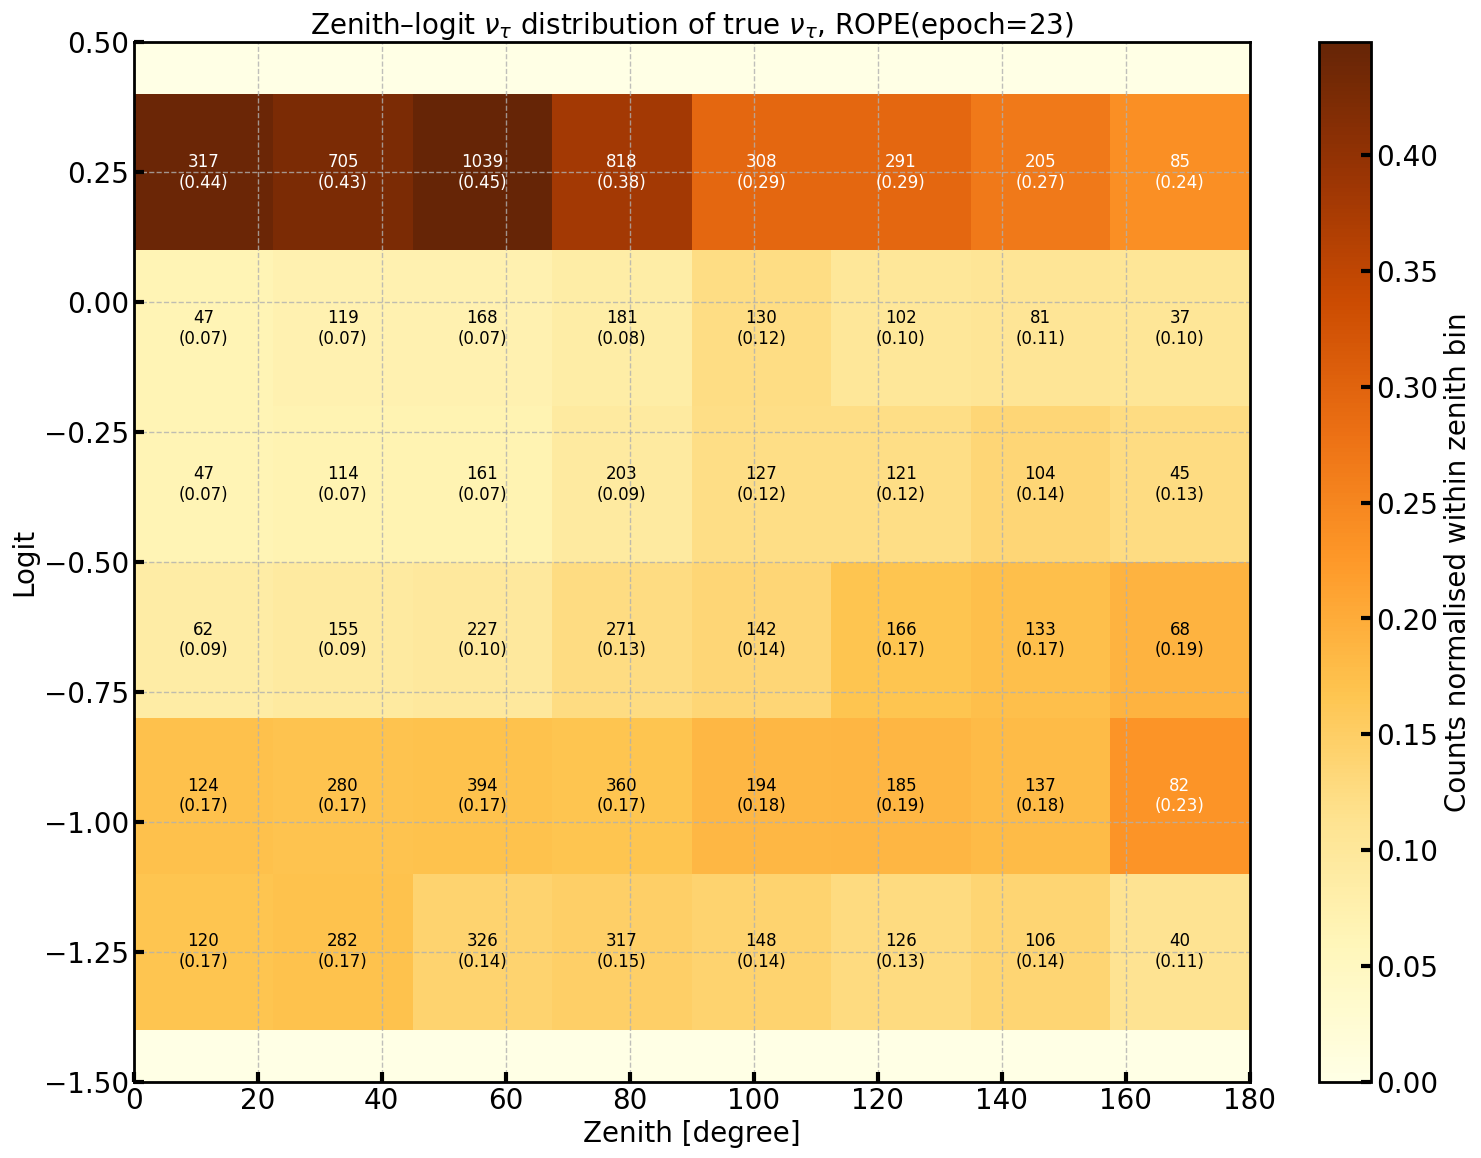

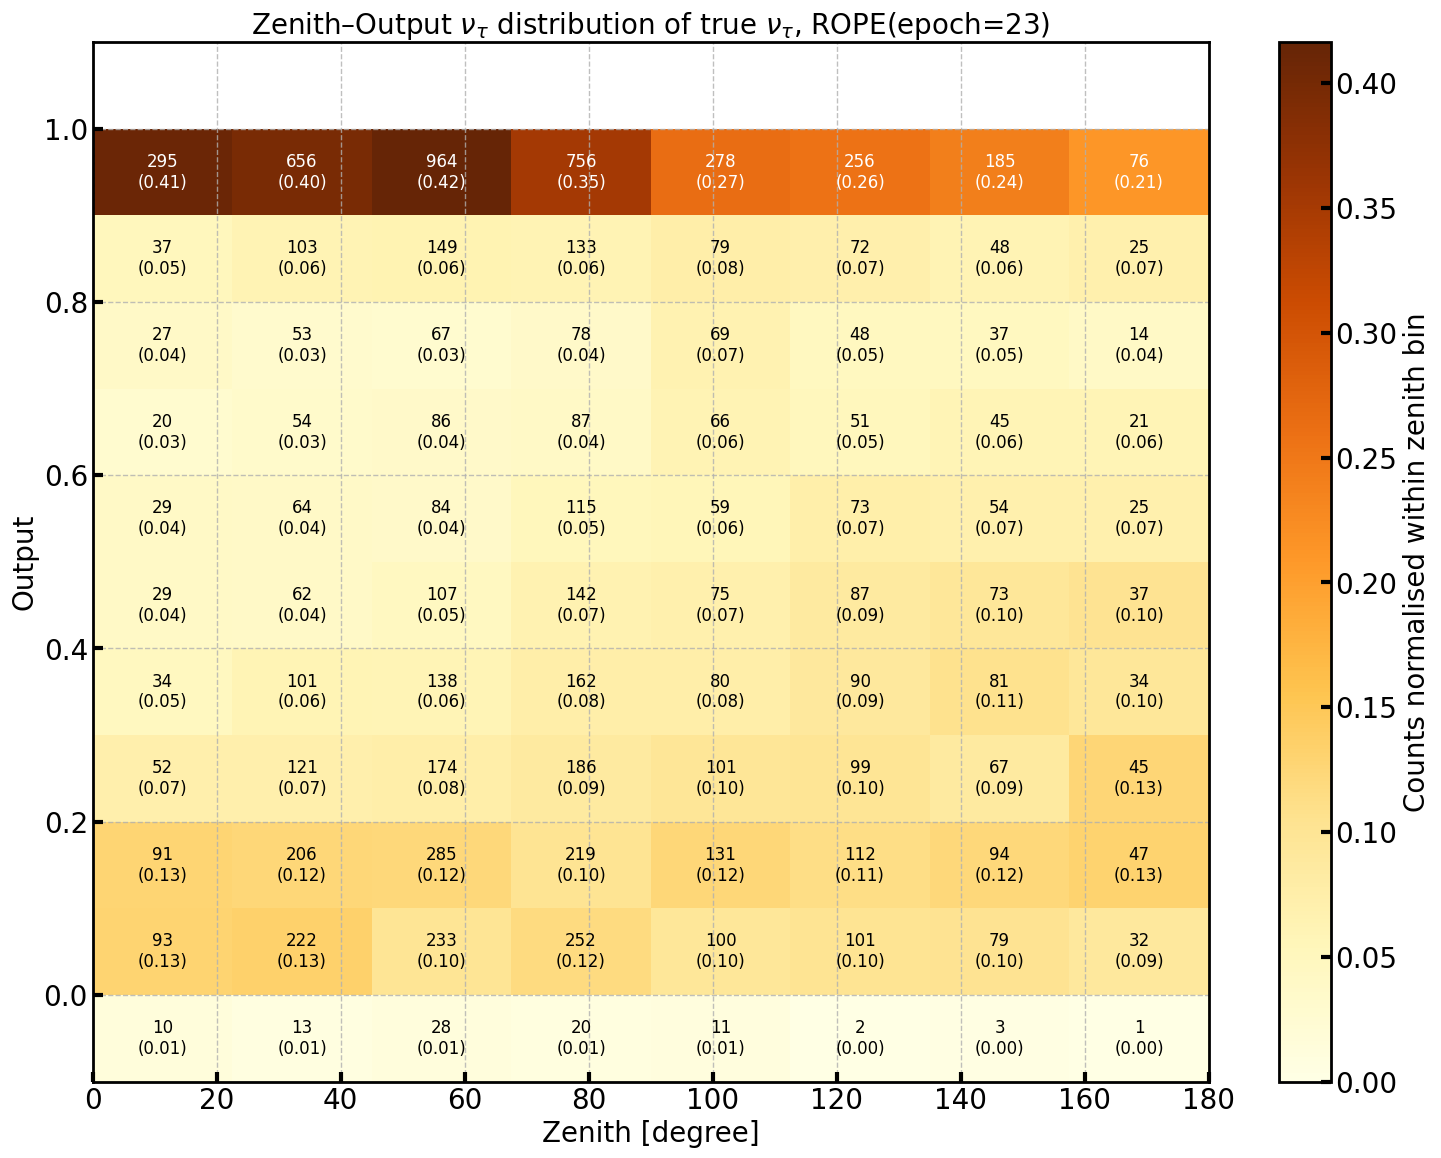

In [105]:
plot_csvs_zenith(csvs)